In [1]:
import pprint
pp = pprint.PrettyPrinter(indent=4)

import pandas as pd
import matplotlib.pyplot as plt
from Graph import *
from math import sqrt

import seaborn as sns
import numpy as np

## Test the Graph class

In [ ]:
vertex1 = Vertex(60, 2, 0)
vertex2 = Vertex(61, 3, 0)

edge = Edge([vertex1, vertex2])

print(edge.angle, edge.length, edge.intermediate_point())

In [ ]:
graph = Graph(warnings = True)

last_vertex = Vertex(-1, -1, 0, warnings = True)
graph.add_vertices(last_vertex)

for i in range(0,10):
    new_vertex = Vertex(i, i, 0, warnings = True)
    edge = Edge(vertices = [last_vertex, new_vertex], warnings = True)
    graph.add_vertices(new_vertex)
    last_vertex = new_vertex

In [ ]:
pp.pprint(graph.vertices)
pp.pprint(graph.edges)
    
for i in range(5):
    cur_vertex = next(iter(graph.vertices))
    cur_vertex.set_graph(None)

    pp.pprint(graph.vertices)
    pp.pprint(graph.edges)
    pp.pprint("")

In [ ]:
print(calculate_angle(60, 61, 2, 3))
print(calculate_angle(60, 61, 3, 2))

## Angle graphifying

In [2]:
df = pd.read_csv("presets/0.csv")

In [3]:
tra = df["trajectory"].unique()[0]
dft = df[df["trajectory"] == tra]

In [11]:
for i in range(1, 10):
    lat0 = dft.iloc[i-1, 0]
    long0 = dft.iloc[i-1, 1]
    
    lat1 = dft.iloc[i, 0]
    long1 = dft.iloc[i, 1]
    
    print(lat0, lat1, long0, long1)
    print(calculate_angle(lat0, lat1, long0, long1)-90)
    print(short_angle(lat0, lat1, long0, long1))
    print("")

39.984683 39.984686 116.31845 116.318417
-7.895692034947103
5.1944289188580575

39.984686 39.984688 116.318417 116.318385
-5.446236596963729
3.5763343670769037

39.984688 39.984655 116.318385 116.318263
22.428000776530723
15.135835504053896

39.984655 39.984611 116.318263 116.318026
15.82064931570045
10.517445787105757

39.984611 39.984608 116.318026 116.317761
0.9953204563904592
0.6486037587924398

39.984608 39.984563 116.317761 116.317517
15.72221035720304
10.449428157398915

39.984563 39.984539 116.317517 116.317294
9.330879465560542
6.142718153447093

39.984539 39.984606 116.317294 116.317065
-24.052630529548537
16.308231335395895

39.984606 39.984568 116.317065 116.316911
20.63504096153173
13.861027562212106



In [ ]:
# Additional idea: combine edges with similar angles
# For report we attempt to model the topology of a city (vertices, edges and planes) of a city from geographical data

### Testing division

In [ ]:
# divide latitude by 69 and longitude by 52

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


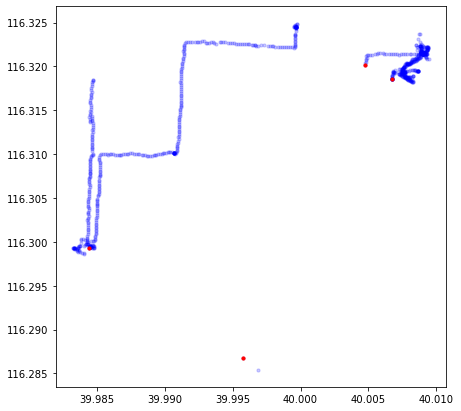

In [12]:
maximum = 0.0014
dft.loc[:, "latitude_change"] = dft.loc[:,"latitude"] - dft.loc[:,"latitude"].shift(1)
dft.loc[:, "longitude_change"] = dft.loc[:,"longitude"] - dft.loc[:,"longitude"].shift(1)

def pythago(lat, long):
    return sqrt(lat*lat + long*long)

dft.loc[:,["change"]] = dft.apply(lambda x: pythago(x.latitude_change, x.longitude_change), axis=1)

maximum = dft.loc[:,"change"].mean()*10
fig, ax = plt.subplots(figsize = (7,7))
ax.scatter(dft.latitude, dft.longitude, zorder=1, alpha= 0.2, c='b', s=10)
ax.scatter(dft[dft["change"] > maximum].latitude, dft[dft["change"] > maximum].longitude, zorder=1, alpha=1, c='r', s=10)

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='change'>

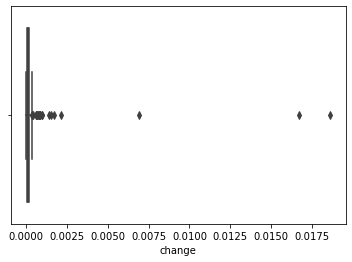

In [13]:
sns.boxplot(dft['change'])

### The actual graph

In [14]:
# Method 1: check if the angle between current and previous vertex is too different from first angle in sequence
# Method 2: check if the angle between current and first vertex in the sequence is too different from first angle in sequence
# Method 3: method 2, but the max angle is affected by the distance from the first vertex in the sequence

def create_graph(df, max_angle_change = 45, method = 3, max_angle_change_min = 5, distance_multiplier = 10):
    mean_distance = df["change"].mean()
    skip_next = False

    graph = Graph()
    
    # The start of the sequence
    start_latitude = df.iloc[0, 0]
    start_longitude = df.iloc[0, 1]
    altitude = df.iloc[0, 2]
    
    # The last point
    start_vertex = Vertex(start_latitude, start_longitude, altitude, graph)
    last_latitude = df.iloc[1, 0]
    last_longitude = df.iloc[1, 1]
    last_altitude = df.iloc[1, 2]
    
    # The last angle
    compare_angle = start_vertex.angle_to_point(last_latitude, last_longitude)

    for i in range(2,len(df)):
        cur_latitude = df.iloc[i, 0]
        cur_longitude = df.iloc[i, 1]   
        cur_altitude = df.iloc[i, 2]
        
        last_distance = sqrt(pow(last_latitude-cur_latitude, 2) + pow(last_longitude-cur_longitude,2))
        
        # If the last iteration noticed a skip, create a new start
        if skip_next == True:
            new_vertex = Vertex(last_latitude, last_longitude, last_altitude, graph)
            
            compare_angle = calculate_angle(start_latitude, cur_latitude, start_longitude, cur_longitude)
            start_vertex = new_vertex

            start_altitude = last_altitude
            start_longitude = last_longitude
            
            skip_next = False            
        
        # If the distance is to large do not connect
        elif last_distance > mean_distance*distance_multiplier:
            new_vertex = Vertex(last_latitude, last_longitude, last_altitude, graph)
            Edge([start_vertex, new_vertex])

            start_vertex = new_vertex

            start_altitude = last_altitude
            start_longitude = last_longitude
            
            skip_next = True
        
        # Normal case of connecting
        else:
            if method == 1:
                last_angle = calculate_angle(last_latitude, cur_latitude, last_longitude, cur_longitude)
                cur_angle = last_angle
                max_angle = max_angle_change

            elif method == 2:
                start_angle = calculate_angle(start_latitude, cur_latitude, start_longitude, cur_longitude)
                cur_angle = start_angle
                max_angle = max_angle_change

            elif method == 3:
                start_angle = calculate_angle(start_latitude, cur_latitude, start_longitude, cur_longitude)
                cur_angle = start_angle
                
                start_distance = sqrt(pow(start_latitude-cur_latitude, 2) + pow(start_longitude-cur_longitude,2))
                max_angle = max(max_angle_change*mean_distance/start_distance, max_angle_change_min)
            
            # If the angle is too different
            if ((abs(compare_angle-cur_angle) + 180) % 360 - 180) > max_angle:
                new_vertex = Vertex(last_latitude, last_longitude, last_altitude, graph)
                Edge([start_vertex, new_vertex])

                compare_angle = cur_angle
                start_vertex = new_vertex

                start_altitude = last_altitude
                start_longitude = last_longitude

        last_latitude = cur_latitude
        last_longitude = cur_longitude
        last_altitude = cur_altitude

    new_vertex = Vertex(last_latitude, last_longitude, last_altitude, graph)
    Edge([start_vertex, new_vertex])
    
    return graph

reduced from 907 to 547 points


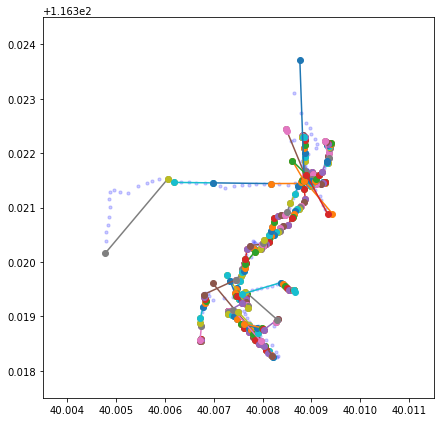

In [37]:
graph = create_graph(dft, method = 1, distance_multiplier = 5, max_angle_change = 4)

fig, ax = plt.subplots(figsize = (7,7))
ax.scatter(dft.latitude, dft.longitude, zorder=1, alpha= 0.2, c='b', s=10)

for edge in graph.edges:
    lat1 = min(edge.vertices).latitude
    long1 = min(edge.vertices).longitude
    
    lat2 = max(edge.vertices).latitude
    long2 = max(edge.vertices).longitude
    
    plt.plot([lat1, lat2], [long1, long2], marker = 'o')

ax = plt.gca()

ax.set_xlim([40.0035, 40.0115])
ax.set_ylim([116.3175, 116.3245])
print(f"reduced from {len(dft)} to {len(graph.vertices)} points")

In [ ]:
for vertex in graph.vertices:
    if len(vertex.edges) == 1:
        cur_vertex = vertex
        cur_edge = next(iter(vertex.edges))
        break
        
cur_angle = cur_edge.angle
cur_vertex = [vertex for vertex in cur_edge.vertices if vertex != cur_vertex][0]
cur_edge = [edge for edge in cur_vertex.edges if edge != cur_edge][0]

while len(cur_vertex.edges) != 1:
    cur_angle = cur_edge.angle
    cur_vertex = [vertex for vertex in cur_edge.vertices if vertex != cur_vertex][0]
    cur_edge = [edge for edge in cur_vertex.edges if edge != cur_edge][0]

In [ ]:
# change gaps into different trajectory
# add distance to angle calculation